<a href="https://colab.research.google.com/github/ellagattis/kuka/blob/main/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

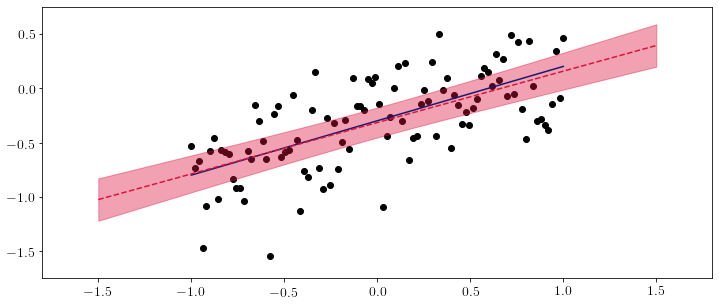

In [ ]:
import numpy as np
from numpy.linalg import multi_dot as mdot
import scipy.stats
import scipy.optimize
import matplotlib.pyplot as plt
import os
import random

%matplotlib inline

os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2017/bin/x86_64-darwin'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams["font.size"] = 14

np.random.seed(20)


def BayesianLinearRegression(x,y,x_test,opt=True):
    
    def MLII(hyperparameters): #empirical Bayesian approach known as type-II maximum likelihood
        noise = np.exp(hyperparameters[0])
        try:
            K = mdot([x,Σ_prior,x.T]) + np.eye(n)*noise
            L = np.linalg.cholesky(K)
            α = np.atleast_2d(np.linalg.solve(L.T,np.linalg.solve(L,y_))).T
            nlZ = np.dot(y_.T,α)/2 + np.log(L.diagonal()).sum() + n*np.log(2*np.pi)/2 #Algorithm 2.1 R&W

            Q = np.linalg.solve(L.T,np.linalg.solve(L,np.eye(n))) - np.dot(α,α.T)
            dnlZ = noise*np.trace(Q) 

        except (np.linalg.LinAlgError) as e:
            nlZ = np.inf ; dnlZ = np.inf
        return nlZ,dnlZ
    
    M = x.shape[1] #number of predictors

    #define the prior w ~ N(0,Σ_prior) eq 2.4 Rasmussen and Williams, 2006
    μ_prior = np.zeros(M) #zero mean prior 
    Σ_prior = np.eye(M)*100 #prior covariance matrix
    y_ = y - np.dot(x,μ_prior) #compute this here for convenience
    
    if opt:
        noise = np.exp(scipy.optimize.minimize(MLII,x0=np.log(.3),method='CG',jac=True).x)
    else:
        noise = .3

    K = mdot([x,Σ_prior,x.T]) + np.eye(n)*noise
    Kxs = mdot([x_test,Σ_prior,x_test.T])
    Kxxs = mdot([x,Σ_prior,x_test.T])
    
    L = np.linalg.cholesky(K)
    α = np.atleast_2d(np.linalg.solve(L.T,np.linalg.solve(L,y_))).T
    v = np.linalg.solve(L,Kxxs)

    return np.dot(x_test,μ_prior) + np.dot(Kxxs.T,α).ravel(), np.sqrt((Kxs - np.dot(v.T,v)).diagonal()) + noise
    

#generate synthetic data
w0_true = -0.3 #for synethetic example
w1_true = 0.5
n = 100 #training points
ns = 140 #test points

x = np.asarray([np.ones(n),np.linspace(-1,1,n)]).T #training inputs
x_test = np.asarray([np.ones(ns),np.linspace(-1.5,1.5,ns)]).T #test inputs
y = (w0_true + x[:,1]*w1_true) + np.random.normal(0,0.3,n) #training targets

#generate regression fit and uncertainty estimates
posterior,error = BayesianLinearRegression(x,y,x_test,opt=True)


fig,ax = plt.subplots(1,figsize=(12,5))
plt.scatter(x[:,1],y,color='k')
plt.plot(x[:,1],w0_true + x[:,1]*w1_true,'midnightblue')
plt.plot(x_test[:,1],posterior,color='crimson',linestyle='--')
plt.fill_between(x_test[:,1],posterior+error,posterior-error,color='crimson',alpha=0.4)
plt.xlim(-1.8,1.8)
plt.ylim(-1.75,0.75)
plt.show()